In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import pickle
import difflib
from collections import Counter

%matplotlib inline
from keras.utils import np_utils

train = pd.read_csv('../train.csv', sep=',', header=0)
test = pd.read_csv('../test.csv', sep=',', header=0)

train = train.fillna(" ")
test = test.fillna(" ")
print(train.shape)

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss



train.head(2)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


(404290, 6)
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [2]:
stop_words = set(stopwords.words('english'))

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1),min_df=4)
tfidf.fit(np.concatenate([train["question1"].values,train["question2"].values]))

def sequence_match(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

#gets a pandas row with specific column names!
def noun_match_ratio(row):
    if(row.z_noun_match == 0): 
        return 0
    else:
        return row.z_noun_match / ((len(row.question1_nouns)+len(row.question2_nouns))/2)

def noun_extracter(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    return np.array([w for w, t in nltk.pos_tag(tokens) if t[:1] in ['N']])
    
def word_match(q1,q2):
    q1 = q1.split()
    q2 = q2.split()
    if(len(q1) == 0 or len(q2) == 0):
        return 0
    else:
        both = set(q1).intersection(set(q2))
        return len(both) * 2 / (len(q1) + len(q2))
    
def removePunktAndStopwords(phrases):
    toInclude = set(['above','below','between','but','couldn','didn','doesn','down',
                     'few','hadn','haven','isn','just','mightn','mustn','needn','nor',
                     'not','off','once','only','out','over','should','shouldn','some',
                     'very','wasn','weren','won','wouldn','again','against','all',
                     'any','aren'])
    stop_wordsLarge = set(stopwords.words('english'))
    stop_words = set(stopwords.words('english'))#set([w for w in stop_wordsLarge if w not in toInclude])
    tokenizer = RegexpTokenizer('[a-z]\w+')
    docs_toke = [tokenizer.tokenize(doc.lower()) for doc in phrases]
    stopwordsremoved = [[t for t in temp if t not in stop_words] for temp in docs_toke]
    return np.asarray([" ".join(w) for w in stopwordsremoved])

def stopWordsRemover(phrase):
    bla = [w for w in str(phrase).lower().split() if w not in stop_words]
    return " ".join(bla)

class LemmaTokenizer(object):
    def __init__(self):
        self.snbstem = SnowballStemmer('english')
    def lmtokenize(self,doc):
        temp = [self.snbstem.stem(t) for t in doc.lower().split()]
        return " ".join(temp)
    

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
def getFeatures(df):
    questions1 = df["question1"].values
    questions2 = df["question2"].values
    df.loc[:,"q1sW"] = df.apply(lambda x: stopWordsRemover(x.question1),axis=1)
    df.loc[:,"q2sW"] = df.apply(lambda x: stopWordsRemover(x.question2),axis=1)
    df = df.assign(question1_nouns=pd.Series(Parallel(n_jobs=5)(delayed(noun_extracter)(x) for x in questions1)))
    df = df.assign(question2_nouns=pd.Series(Parallel(n_jobs=5)(delayed(noun_extracter)(x) for x in questions2)))
    df.loc[:,'z_len1'] = df.question1.map(lambda x: len(str(x)))
    df.loc[:,'z_len2'] = df.question2.map(lambda x: len(str(x)))
    df.loc[:,'z_word_len1'] = df.question1.map(lambda x: len(str(x).split()))
    df.loc[:,'z_word_len2'] = df.question2.map(lambda x: len(str(x).split()))
    df.loc[:,'z_noun_match'] = df.apply(lambda r: sum([1 for w in r["question1_nouns"] if w in r["question2_nouns"]]), axis=1) 
    df.loc[:,'z_noun_match_ratio'] = df.apply(lambda r: noun_match_ratio(r), axis=1)
    df = df.assign(z_sequence_match=pd.Series(Parallel(n_jobs=5)
                                       (delayed(sequence_match)(x,y) for x,y in zip(df["q1sW"].values,df["q2sW"].values))))
    df = df.assign(z_word_match=pd.Series(Parallel(n_jobs=5)
                                      (delayed(word_match)(x,y) for x,y in zip(df["q1sW"].values,df["q2sW"].values))))
    
    preprocessor = LemmaTokenizer()
    df = df.assign(q1_stemmed=pd.Series(Parallel(n_jobs=5)(delayed(
                    preprocessor.lmtokenize)(sentence) for sentence in df["q1sW"].values)))
    df = df.assign(q2_stemmed=pd.Series(Parallel(n_jobs=5)(delayed(
                preprocessor.lmtokenize)(sentence) for sentence in df["q2sW"].values)))
    
    tfidfQ1 = tfidf.transform(df["question1"])
    tfidfQ2 = tfidf.transform(df["question2"])
    df.loc[:,'z_tfidf_sum1'] = pd.Series(np.squeeze(np.asarray(tfidfQ1.sum(axis=1))))
    df.loc[:,'z_tfidf_sum2'] = pd.Series(np.squeeze(np.asarray(tfidfQ2.sum(axis=1))))
    df.loc[:,'z_tfidf_mean1'] = pd.Series(np.squeeze(np.asarray(tfidfQ1.mean(axis=1))))
    df.loc[:,'z_tfidf_mean2'] = pd.Series(np.squeeze(np.asarray(tfidfQ2.mean(axis=1))))
    
    return df
    

test = getFeatures(test)

#pickle.dump(test,open("dumps/tasdfasdfafFeatures04-11.p", "wb" ))
col = [c for c in test.columns if c[:1]=='z']

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [5]:
import pickle
train = pickle.load(open("dumps/trainFeatures04-10.p", "rb" ))
test = pickle.load(open("dumps/testFeatures04-10.p", "rb" ))
col = [c for c in train.columns if c[:1]=='z']

def addfeature(df):
    print("muhmaeh")
    return df
    
#train = addfeature(train)

In [7]:
def upsampleNegatives(X,y):
    negs = np.sum(y == 0)
    pos = np.sum(y == 1)
    negIncrease = int(pos / 0.165) - negs
    negidx= np.nonzero(y == 0)[0]
    idx = np.random.randint(low=0,high=negidx.shape[0],size=negIncrease)
    Xnew = np.concatenate([X,X[negidx[idx]]])
    ynew = np.concatenate([y,y[negidx[idx]]])
    return Xnew, ynew

def upsampleNegativesCreative(X,y):
    #sample better here
    return X,y
    
    


X_train, X_test, y_train, y_test = train_test_split(train[col].values, train["is_duplicate"].values, test_size=0.2)
X2,y2 = upsampleNegatives(X_test,y_test)
X1,y1 = upsampleNegatives(X_train,y_train)

In [20]:
# xgb api with additional methods and params 

X_train, X_test, y_train, y_test = train_test_split(train[col].values, train["is_duplicate"].values, test_size=0.2)

# num_testing = 100000
# X_train = train[col].values[num_testing:]
# X_test = train[col].values[:num_testing]
# y_train = train["is_duplicate"].values[num_testing:]
# y_test = train["is_duplicate"].values[:num_testing]
# # classification

#Dtrain = xgb.DMatrix(X_train,y_train,feature_names=col)
Dtrain = xgb.DMatrix(X1,y1,feature_names=col) 
#Dtest = xgb.DMatrix(X_test,y_test,feature_names=col) 
Dvalid = xgb.DMatrix(X2,y2,feature_names=col)

params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["max_depth"] = 6
#taking fancy params from matching que for quora gives ~0.02 worse valid logloss and kaggle result

watchlist = [(Dvalid,"valid")]

bst = xgb.train(params, Dtrain, 300, watchlist, early_stopping_rounds=20, verbose_eval=10)
#pickle.dump(bst,open("xgb.p","wb"))

#Testing different settings: depth 6 for all, valid logloss displayed
# normal no upsampling 0.421217
# upsampling everything, train and test: 0.28344: after round ~130 no improvement. BUT on kaggle: 0.34
# !!!!!upsampling only test set: round 1590: 0.255242 still decreasing. BUT on Kaggle: 0.40

[0]	valid-logloss:0.541056
Will train until valid-logloss hasn't improved in 20 rounds.
[10]	valid-logloss:0.307862
[20]	valid-logloss:0.298075
[30]	valid-logloss:0.295455
[40]	valid-logloss:0.29334
[50]	valid-logloss:0.291916
[60]	valid-logloss:0.290903
[70]	valid-logloss:0.290173
[80]	valid-logloss:0.28934
[90]	valid-logloss:0.288621
[100]	valid-logloss:0.28837
[110]	valid-logloss:0.287884
[120]	valid-logloss:0.287229
[130]	valid-logloss:0.286976
[140]	valid-logloss:0.286541
[150]	valid-logloss:0.286366
[160]	valid-logloss:0.286097
[170]	valid-logloss:0.285907
[180]	valid-logloss:0.285636
[190]	valid-logloss:0.285335
[200]	valid-logloss:0.285057
[210]	valid-logloss:0.284733
[220]	valid-logloss:0.284615
[230]	valid-logloss:0.284457
[240]	valid-logloss:0.284225
[250]	valid-logloss:0.284104
[260]	valid-logloss:0.283704
[270]	valid-logloss:0.283602
[280]	valid-logloss:0.283522
[290]	valid-logloss:0.283529


In [18]:
#bst = pickle.load(open("xgb.p","rb"))
Dtest = xgb.DMatrix(test[col].values,feature_names=col)
preds = bst.predict(Dtest)

test["is_duplicate"] = pd.Series(preds,index=test.index)
header = ["test_id", "is_duplicate"]
test.to_csv('../submissions/predictions.csv', columns = header,index=False)

In [8]:
#looking at wrong questions needs indices aligned in Dvalid and train dataframe aligned!!
preds = bst.predict(Dvalid)
errors = np.abs(preds-y_test)
idx = np.argsort(errors)[::-1]
error2 = y_test-preds
plt.hist(error2,30)

for i in range(2):
    print(train.iloc[idx[i],3:5].values)
    print("error: %.3f with preds %.3f and truth %i" %(errors[idx[i]],preds[idx[i]],y_test[idx[i]]))

['Importance of information technology?'
 'What is the extent of paid media in India?']
error: 1.000 with preds 0.000 and truth 1
['Which are the best anime?' 'What are some of the best anime shows?']
error: 1.000 with preds 0.000 and truth 1


In [18]:
from xgboost import plot_tree
%matplotlib 
plot_tree(bst,num_trees=4)

Using matplotlib backend: TkAgg


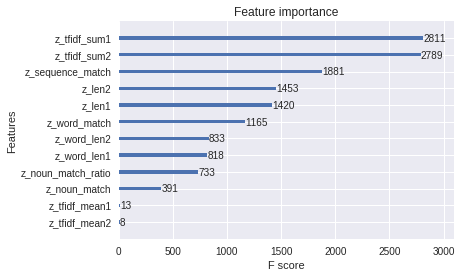

In [21]:
# I don't understand this. with fancy settings from "matching que for quora" the ratings make sense
# just using standard settings, stupid featlengths and tfidf sums 
#plt.rcParams['figure.figsize'] = (0, 4.0)
xgb.plot_importance(bst); plt.show()